In [1]:
# # google colab + google drive sync
# from google.colab import drive
# drive.mount('/content/gdrive/')
# !ls
# %cd gdrive/MyDrive/Colab Notebooks/G-ABC-Infection/AI-Infection-main

# # library install
# !pip install gpytorch
# # requirements.txt file generation
# !pip freeze > requirements.txt

In [1]:
import pandas as pd
import numpy as np
import xlrd
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import os
import random
from gpytorch.mlls import SumMarginalLogLikelihood
from itertools import repeat

In [2]:
''' fix random seed for reproduce '''
random_seed = 1000
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# 경로 설정

In [4]:
save_date = "211119"

## python input data
path_ = "../../../../01_data/국제/수집데이터_211105.xlsx" #국제 데이터
path_2 = '../../../../01_data/국내/covid19_Nov2.csv'

## image
save_path = "../../../../04_image/"+save_date+"/"+save_date+"/TSA/GP/"

# 데이터 로드 및 전처리

In [5]:
start_date = pd.Timestamp('2020-01-01')
observed_end_date = pd.Timestamp('2021-10-05')
end_date = pd.Timestamp('2023-12-31')

In [6]:
file_name_date = '20231231'
start_date = pd.Timestamp('2020-01-01')        
data_start_date = pd.Timestamp('2020-01-22')   # 확진자, 사망자 데이터 시작일
observed_end_date = pd.Timestamp('2021-10-04') # "사망자 데이터 통합"등에 기록된 최종 일자
pre_date = pd.Timestamp('2021-10-05')          # 예측 시작 날짜
end_date = pd.Timestamp('2023-12-31')
train_date = pd.date_range(start_date,observed_end_date)
test_date = pd.date_range(observed_end_date,end_date)
date = pd.date_range(start_date,end_date)

In [7]:
''' data read '''
x_holiday = pd.read_excel(path_,sheet_name='국가별공휴일',engine='openpyxl')#2020-01-01~2024-12-25
x_dist = pd.read_excel(path_,sheet_name='사회적거리두기_Score',engine='openpyxl')#2020-01-01~2021-10-12
x_vaccine = pd.read_excel(path_,sheet_name='백신접종자수',engine='openpyxl') #2021-02-26~2021-10-11
x_weather = pd.read_excel(path_,sheet_name='국가별수도날씨',engine='openpyxl')#2020-01-01 ~2021-10-11
x_population = pd.read_excel(path_,sheet_name='국가별인구수',engine='openpyxl')#no date
x_variant = pd.read_excel(path_,sheet_name='변이바이러스 비율',engine='openpyxl')#2020-04-27~2021-09-13
y_inspection = pd.read_excel(path_,sheet_name='검사자 데이터 통합',engine='openpyxl')#2020-01-01 ~2021-10-12
#y_severity = pd.read_excel(path_,sheet_name='확진자 관리현황',engine='openpyxl')# 2020-09-15 ~2021-10-06
y_infection = pd.read_excel(path_,sheet_name='확진자 데이터 통합',engine='openpyxl')#2020-01-22~2021-10-12
y_death = pd.read_excel(path_,sheet_name='사망자 데이터 통합',engine='openpyxl')#2020-01-22 ~2021-10-12

In [8]:
#y_infection = pd.read_excel(path_,sheet_name='확진자 데이터 통합',engine='openpyxl')#2020-01-22~2021-10-12
y_infection['tDate'][-30:-5]

598   2021-09-11
599   2021-09-12
600   2021-09-13
601   2021-09-14
602   2021-09-15
603   2021-09-16
604   2021-09-17
605   2021-09-18
606   2021-09-19
607   2021-09-20
608   2021-09-21
609   2021-09-22
610   2021-09-23
611   2021-09-24
612   2021-09-26
613   2021-09-27
614   2021-09-28
615   2021-09-29
616   2021-09-30
617   2021-10-01
618   2021-10-02
619   2021-10-04
620   2021-10-05
621   2021-10-06
622   2021-10-07
Name: tDate, dtype: datetime64[ns]

In [9]:
y_infection['tDate'][619]

Timestamp('2021-10-04 00:00:00')

In [10]:
#y_death = pd.read_excel(path_,sheet_name='사망자 데이터 통합',engine='openpyxl')#2020-01-22 ~2021-10-12
y_infection['South Korea'][619]

3757

In [11]:
#이유엔데이터 중증자#
data_sev_1= pd.read_excel(path_,engine = "openpyxl",sheet_name ='확진자 관리현황',usecols = 'A,H' )

sev_start_date = data_sev_1['tDate'][0]                # 시작 날짜(이전의 데이터를 붙이기 위해 필요)
sev_end_date = data_sev_1['tDate'][len(data_sev_1)-1]  # 끝 날짜 (이후의 데이터를 붙이기 위해 필요)

data_sev_1.rename(columns = {'TodayIllPatient':'Severity'}, inplace = True)
data_sev_1_2 = data_sev_1.fillna(0)
data_sev_1_2

,tDate,Severity
0,2020-09-15,158
1,2020-09-16,160
2,2020-09-17,160
3,2020-09-18,150
4,2020-09-19,152
...,...,...
382,2021-10-02,336
383,2021-10-03,346
384,2021-10-04,348
385,2021-10-05,346


In [12]:
## 아리마에서 사용한 중증자 초기 데이터 ##2020-01-20~2020-09-14
data_sev_2 = pd.read_csv(path_2,usecols=[0,6])
data_sev_2['Date'] = pd.to_datetime(data_sev_2['Date'])
old_sev = data_sev_2.loc[data_sev_2['Date']<data_sev_1['tDate'][0]]
old_sev.rename(columns = {'Date' : 'tDate'}, inplace = True)
old_sev_1 = old_sev.fillna(0)
old_sev_1

/home/sysadm/anaconda3/envs/heytrt3.7/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,tDate,Severity
0,2020-01-20,0.0
1,2020-01-21,0.0
2,2020-01-22,0.0
3,2020-01-23,0.0
4,2020-01-24,0.0
...,...,...
234,2020-09-10,169.0
235,2020-09-11,175.0
236,2020-09-12,164.0
237,2020-09-13,157.0


In [13]:
#데이터합치기#
data_sev = pd.concat([old_sev_1,data_sev_1_2],ignore_index=True)
data_sev

,tDate,Severity
0,2020-01-20,0.0
1,2020-01-21,0.0
2,2020-01-22,0.0
3,2020-01-23,0.0
4,2020-01-24,0.0
...,...,...
621,2021-10-02,336.0
622,2021-10-03,346.0
623,2021-10-04,348.0
624,2021-10-05,346.0


In [14]:
## 확진자 튀는 데이터...
y_infection = y_infection.fillna(0)
y_death = y_death.fillna(0)
y_infection.loc[y_infection['tDate']=='2021-09-26','South Korea']= 2771
y_infection.loc[y_infection['tDate']=='2021-10-04','South Korea']= 1673

## 확진자, 사망자 -999 -> 0
y_infection.loc[y_infection['South Korea']== -999,'South Korea']= 0
y_death.loc[y_death['South Korea']== -999,'South Korea']= 0

In [15]:
country_list = y_inspection.columns.values.tolist()[1:]
country_idx_dict = {key:val for val,key in enumerate(country_list)}

num_country = len(country_list)
td = (end_date - start_date).days + 1 # total date, 2020-01-02 - 2020-01-01 = 1

# GP에 넣기 위한 빈공간 생성
x = np.zeros((6,num_country,td)) # 6: 날짜 + 위 셀에서 불러온 데이터 x 5개 (국가별인구수는 제외)
y = np.zeros((3,num_country,td)) # 3: 검사자, 확진자, 사망자

In [16]:
# 인구수
country_population_dict = {}
for row in x_population.iterrows():
  country, pro1, pro2, num = row[1]
  if type(pro1) == float:
    country_population_dict[country] = num
country_population_dict['Czechia'] = 10650000
country_population_dict['Latvia'] = 1920000
country_population_dict['US'] = 328200000

In [17]:
# 날짜 
# 규칙: 0,1,2,3,4,...
for itr in range(td):
  x[0,:,itr] = itr 

In [18]:
# x_holiday 전처리
# 규칠: 공휴일:1 , 그 외: 0
for row in x_holiday.iterrows():
  current_date, country, _ = row[1]
  idx = (current_date - start_date).days
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    x[1,country_idx_dict[country],idx] = 1

In [19]:
# x_dist 전처리
# 규칙: 항목별 score 평균 (province별로 존재할 경우, 이 또한 평균)
country_end_dict = {}
group_x_dist = x_dist.groupby(['tDate', 'Country']).mean() # province별로 존재할 경우, 평균
for row in group_x_dist.iterrows():
  current_date, country = row[0]
  idx = (current_date - start_date).days
  dist = np.mean(row[1])
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    if (dist == 0) and (idx>0): # 관측되었지만, 0으로 누락된 경우를 고려하기 위함
      x[2,country_idx_dict[country],idx] = x[2,country_idx_dict[country],idx-1]
    else:
      x[2,country_idx_dict[country],idx] = dist
  country_end_dict[country] = idx
  
for country,country_end_idx in country_end_dict.items():
  if country in country_idx_dict:
    for itr in range(country_end_idx,td):
      x[2,country_idx_dict[country],itr] = x[2,country_idx_dict[country],country_end_idx]

In [23]:
x[2,country_idx_dict['South Korea'],range(country_end_idx,td)]

array([41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222222,
       41.7222222, 41.7222222, 41.7222222, 41.7222222, 41.7222

In [20]:
# x_vaccine 전처리
# 규칙: 1차 백신 접종자수만 기록하되, 누적하여 기록 (0으로 결측일 경우, 그 이전 max 값 그대로 가져오기)
# 최신 날짜부터, 2021-12-31까지는 상수로 값 유지
country_end_dict = {}
for row in x_vaccine.iterrows():
  current_date, country, num_vaccine, _ = row[1]
  idx = (current_date - start_date).days
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    x[3,country_idx_dict[country],idx] = np.maximum(num_vaccine, x[3,country_idx_dict[country],idx-1])
  country_end_dict[country] = idx

# 각 국가별 최신 날짜부터, 2021-12-31까지는 상수로 값 유지
for country,country_end_idx in country_end_dict.items():
  if country in country_idx_dict:
    for itr in range(country_end_idx,td):
      x[3,country_idx_dict[country],itr] = x[3,country_idx_dict[country],country_end_idx]

In [22]:
x[3,country_idx_dict['South Korea'],range(country_end_idx,td)]/country_population_dict['South Korea']

array([0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048311,
       0.78048311, 0.78048311, 0.78048311, 0.78048311, 0.78048

In [21]:
# x_weather 전처리
# 규칙: Temp만 기록, city 별로는 평균
# 최신날짜부터, 2021-12-31까지는 1년전 값 유지
group_x_weather = x_weather.groupby(['tDate', 'Country']).mean() # province별로 존재할 경우, 평균
for row in group_x_weather.iterrows():
  current_date, country = row[0]
  idx = (current_date - start_date).days
  temp = row[1][0]
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    x[4,country_idx_dict[country],idx] = temp
for itr in range(idx,td):
    #print(itr)
    x[4,:,itr] = x[4,:,itr-365]

In [22]:
# x_variant 전처리
# 규칙: 21A.Delta 기록
# 최신 날짜부터, 2021-12-31까지는 상수로 값 유지
# 중간 중간 빈 값은, 그 이전 값을 그대로 유지
country_end_dict = {}
prev_idx = 0
for row in x_variant.iterrows():
  country, current_date,variant,_,_,proportion = row[1]
  if variant == '21A.Delta':
    idx = (current_date - start_date).days
    if (idx >= 0) and (idx < td) and (country in country_idx_dict):
      x[5,country_idx_dict[country],prev_idx+1:idx+1] = proportion
    prev_idx = idx
    country_end_dict[country] = idx

# 각 국가별 최신 날짜부터, 2021-12-31까지는 상수로 값 유지
for country,country_end_idx in country_end_dict.items():
  if country in country_idx_dict:
    for itr in range(country_end_idx,td):
      x[5,country_idx_dict[country],itr] = x[5,country_idx_dict[country],country_end_idx]

In [23]:
pre_date2 = pd.Timestamp('2020-01-01')          
end_date2 = pd.Timestamp('2021-10-06')
train_date2 = pd.date_range(pre_date2,end_date2)

In [24]:
y_inspection = pd.read_excel(path_,sheet_name='검사자 데이터 통합',engine='openpyxl')#2020-01-01 ~2021-10-12

In [25]:
#y_inspection 프레임에 중증자 데이터를 넣기 
#y_inspection[y_inspection['tDate'].isin(train_date2)]
y_severity  = y_inspection 
pre_date2 = pd.Timestamp('2020-01-01')          
end_date2 = pd.Timestamp('2021-10-06')
train_date2 = pd.date_range(pre_date2,end_date2)

#1월 20일
for country,country_idx in country_idx_dict.items():
    for i in range(0,len(y_inspection)):
        if i in range(19,19+len(data_sev)): #1월 20일부터데이터가 있으니까 
            y_severity[country][i] = data_sev['Severity'][i-19]
        else:
            y_severity[country][i] = 0
            


/home/sysadm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sysadm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [26]:
y_severity.tail(10)

,tDate,Australia,Austria,Belgium,Canada,Chile,China,Colombia,Costa Rica,Czechia,...,Slovakia,Slovenia,South Korea,Spain,Sweden,Switzerland,Taiwan,Turkey,United Kingdom,US
641,2021-10-03,346,346,346,346,346,346,346,346,346,...,346,346,346,346,346,346,346,346,346,346
642,2021-10-04,348,348,348,348,348,348,348,348,348,...,348,348,348,348,348,348,348,348,348,348
643,2021-10-05,346,346,346,346,346,346,346,346,346,...,346,346,346,346,346,346,346,346,346,346
644,2021-10-06,354,354,354,354,354,354,354,354,354,...,354,354,354,354,354,354,354,354,354,354
645,2021-10-07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
646,2021-10-08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
647,2021-10-09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
648,2021-10-10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
649,2021-10-11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
650,2021-10-12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
y_severity ['South Korea'][644]

354

In [28]:
x.shape

(6, 40, 1461)

In [29]:
y_severity.shape

(651, 41)

In [30]:
y_infection

,tDate,Australia,Austria,Belgium,Canada,Chile,China,Colombia,Costa Rica,Czechia,...,Slovakia,Slovenia,South Korea,Spain,Sweden,Switzerland,Taiwan,Turkey,United Kingdom,US
0,2020-01-22,-999,-999,-999,-999,-999,0,-999,-999,-999,...,-999,-999,0,-999,-999,-999,0,-999,-999,0
1,2020-01-23,0,-999,-999,-999,-999,92,0,-999,-999,...,-999,-999,0,-999,-999,-999,0,-999,-999,0
2,2020-01-24,-999,-999,-999,-999,-999,277,-999,-999,-999,...,-999,-999,1,-999,-999,-999,2,-999,-999,0
3,2020-01-25,4,-999,-999,-999,-999,483,-999,-999,-999,...,-999,-999,0,-999,-999,-999,0,-999,-999,0
4,2020-01-26,0,-999,-999,0,-999,663,-999,-999,-999,...,-999,-999,1,-999,-999,-999,1,-999,-999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,2021-10-08,2524,1965,2497,4111,942,29,1677,1617,1048,...,1451,969,2172,1807,835,1125,4,29989,39898,100083
624,2021-10-09,2515,1878,2414,4199,986,21,1607,1368,997,...,1690,841,1949,2309,739,966,12,30201,35120,131142
625,2021-10-10,2390,1868,0,1596,998,32,1587,0,1013,...,1793,885,1594,0,0,0,4,28645,39493,27501
626,2021-10-11,2096,1675,0,1596,1063,25,1518,0,669,...,1162,489,1297,0,0,0,7,28370,33654,22194


In [31]:
# y 전처리
for country,country_idx in country_idx_dict.items():

  country_severity = y_severity[country]
  country_infection = y_infection[country]
  country_death = y_death[country]

  y[0,country_idx,:len(country_severity)] = country_severity # from 2020-01-01
  y[1,country_idx,21:21+len(country_death)] = country_infection # from 2020-01-22
  y[2,country_idx,21:21+len(country_death)] = country_death # from 2020-01-22



In [32]:
# x 최종 전처리 (0~1사이의 범위로 변경)
x[0,:,:] = x[0,:,:]/td # 날짜
x[1,:,:] = x[1,:,:] # 그대로 0,1
x[2,:,:] = x[2,:,:]/100 # 거리두기 score
for country,country_idx in country_idx_dict.items():
  x[3,country_idx,:] = x[3,country_idx,:]/country_population_dict[country] # vaccine
x[4,:,:] = x[4,:,:]/np.max(x[4,:,:]) # weather
x[5,:,:] = x[5,:,:] # variant

In [33]:
max_list = []
for country,country_idx in country_idx_dict.items():
  max_list.append([np.max(y[0,country_idx,:]),np.max(y[1,country_idx,:]),np.max(y[2,country_idx,:])])

In [34]:
# y 최종 전처리 (0~1사이의 범위로 변경)
max_list = []
for country,country_idx in country_idx_dict.items():
  max_list.append([np.max(y[0,country_idx,:]),np.max(y[1,country_idx,:]),np.max(y[2,country_idx,:])])
  y[0,country_idx,:] = y[0,country_idx,:]/np.max(y[0,country_idx,:]) # inspection
  y[1,country_idx,:] = y[1,country_idx,:]/np.max(y[1,country_idx,:]) # infection
  y[2,country_idx,:] = y[2,country_idx,:]/np.max(y[2,country_idx,:]) # death
  # y[0,country_idx,:] = y[0,country_idx,:]/country_population_dict[country] # inspection
  # y[1,country_idx,:] = y[1,country_idx,:]/country_population_dict[country] # infection
  # y[2,country_idx,:] = y[2,country_idx,:]/country_population_dict[country] # death

In [35]:
# numpy to pytorch tensor
torch_x = torch.from_numpy(x).float()
torch_y = torch.from_numpy(y).float()
print(x.shape,y.shape,torch.max(torch_x),torch.max(torch_y[2,:,:]))

(6, 40, 1461) (3, 40, 1461) tensor(1.) tensor(1.)


In [36]:
# train, test split
start_point = (pd.Timestamp('2020-09-01') - start_date).days # we remove data before 2020-09-01, many values are one or zero
# start_point = 366 # 2021-01-01 0~29: many values are one or zero
end_point = (observed_end_date-start_date).days

train_date = date[start_point:end_point]
train_x = torch_x[:,:,start_point:end_point]
train_y = torch_y[:,:,start_point:end_point]

test_date = date[end_point:]
test_x = torch_x[:,:,end_point:]
test_y = torch_y[:,:,end_point:]

print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

torch.Size([6, 40, 398]) torch.Size([6, 40, 819]) torch.Size([3, 40, 398]) torch.Size([3, 40, 819])


In [37]:
x.shape

(6, 40, 1461)

In [38]:
y.shape

(3, 40, 1461)

In [39]:
train_y.shape


torch.Size([3, 40, 398])

In [40]:
y_severity['tDate'][start_point:end_point]

244   2020-09-01
245   2020-09-02
246   2020-09-03
247   2020-09-04
248   2020-09-05
         ...    
637   2021-09-29
638   2021-09-30
639   2021-10-01
640   2021-10-02
641   2021-10-03
Name: tDate, Length: 398, dtype: datetime64[ns]

In [41]:
data_dim = train_x.size(0)
feature_dim = 10
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 64))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(64, 32))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(32, feature_dim))

feature_extractor = LargeFeatureExtractor()

In [42]:
# initialize model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()+gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=10)*gpytorch.kernels.PeriodicKernel()+gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()+gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel()*gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=6)*gpytorch.kernels.PeriodicKernel()+gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.LinearKernel())
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=feature_dim))
        # self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=5,ard_num_dims=feature_dim)
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)
        self.feature_extractor = feature_extractor

    def forward(self, x):
        projected_x = self.feature_extractor(x)
        projected_x = self.scale_to_bounds(projected_x)
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [43]:
# initialize likelihood
model_list = []
likelihood_list = []
num_country = len(country_idx_dict)
'''
한국, 영국, 미국에 대해서 multi-output gp
'''
target_country_list = [32,38,39] # South Korea, United Kingdom, UK
for mode_itr in [0,1,2]: # 1: infection', 2: death
  for itr in range(num_country):
    if itr in target_country_list:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      model = ExactGPModel(train_x[:,itr,:].T, train_y[mode_itr,itr,:], likelihood)
      model_list.append(model)
      likelihood_list.append(model.likelihood)

In [44]:
model = gpytorch.models.IndependentModelList(*model_list)
likelihood = gpytorch.likelihoods.LikelihoodList(*likelihood_list)

In [45]:
# Use the adam optimizer
training_iter = 700
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

In [46]:
# training
model.train()
likelihood.train()

# "Loss" for GPs - the marginal log likelihood
mll = SumMarginalLogLikelihood(likelihood, model)
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    #print(output)
    loss = -mll(output, model.train_targets)
    loss.backward()
    optimizer.step()
    if i%10 == 0:
      print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))

Iter 1/700 - Loss: 0.771
Iter 11/700 - Loss: 0.727
Iter 21/700 - Loss: 0.689
Iter 31/700 - Loss: 0.651
Iter 41/700 - Loss: 0.612
Iter 51/700 - Loss: 0.572
Iter 61/700 - Loss: 0.531
Iter 71/700 - Loss: 0.489
Iter 81/700 - Loss: 0.447
Iter 91/700 - Loss: 0.403
Iter 101/700 - Loss: 0.359
Iter 111/700 - Loss: 0.313
Iter 121/700 - Loss: 0.270
Iter 131/700 - Loss: 0.222
Iter 141/700 - Loss: 0.174
Iter 151/700 - Loss: 0.127
Iter 161/700 - Loss: 0.080
Iter 171/700 - Loss: 0.032
Iter 181/700 - Loss: -0.018
Iter 191/700 - Loss: -0.060
Iter 201/700 - Loss: -0.112
Iter 211/700 - Loss: -0.160
Iter 221/700 - Loss: -0.206
Iter 231/700 - Loss: -0.254
Iter 241/700 - Loss: -0.302
Iter 251/700 - Loss: -0.346
Iter 261/700 - Loss: -0.395
Iter 271/700 - Loss: -0.437
Iter 281/700 - Loss: -0.481
Iter 291/700 - Loss: -0.528
Iter 301/700 - Loss: -0.570
Iter 311/700 - Loss: -0.611
Iter 321/700 - Loss: -0.653
Iter 331/700 - Loss: -0.698
Iter 341/700 - Loss: -0.727
Iter 351/700 - Loss: -0.773
Iter 361/700 - Loss: 

In [47]:
# testing
concat_train_x = []
concat_test_x = []
for mode_itr in [0,1,2]:
  for itr in range(num_country):
    if itr in target_country_list:
      concat_train_x.append(train_x[:,itr,:].T)
      concat_test_x.append(test_x[:,itr,:].T)

model.eval()
likelihood.eval()
estimations = likelihood(*model(*concat_train_x))
predictions = likelihood(*model(*concat_test_x))

/home/sysadm/anaconda3/envs/heytrt3.7/lib/python3.6/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


In [48]:
def origin_plot_figure(target_country,mode):
  target_country_population = country_population_dict[target_country]
  name = file_name_date+'_None_None_None'
  if mode == 0:
    folder_name = 'S/'
    if target_country == 'South Korea':
      data = y_severity
      target_country_idx = 0
      y_lim = [-300,1000]
    elif target_country == 'United Kingdom':
      target_country_idx = 1
      y_lim = [-1000,80000]
    elif target_country == 'US':
      target_country_idx = 2
      y_lim = [-1000,450000]

  if mode == 1:
    folder_name = 'I/'
    if target_country == 'South Korea':
      data = y_infection.iloc[:,[0,33]]
      target_country_idx = 3
      y_lim = [-300,6000]
    elif target_country == 'United Kingdom':
      target_country_idx = 4
      y_lim = [-1000,80000]
    elif target_country == 'US':
      target_country_idx = 5
      y_lim = [-1000,450000]
  elif mode == 2:
    folder_name = 'D/'
    if target_country == 'South Korea':
      data = y_death.iloc[:,[0,33]]
      target_country_idx = 6
      y_lim = [-10,100]
    elif target_country == 'United Kingdom':
      target_country_idx = 7
      y_lim = [-1000,3000]
    elif target_country == 'US':
      target_country_idx = 8
      y_lim = [-1666,5000]

  submodel = model.models[target_country_idx]
  estimation = estimations[target_country_idx]
  prediction = predictions[target_country_idx]
  max_value = max_list[country_idx_dict[target_country]][mode]

  lower, upper = prediction.confidence_region()
  tr_x = submodel.train_inputs[0].detach().numpy()[:,0]
  tr_y = submodel.train_targets.detach().numpy()
  # Plot training data as black stars
  plt.plot(tr_x, tr_y*max_value, 'k*')

  # Predictive mean as blue line
  plt.plot(train_x[0,country_idx_dict[target_country],:].numpy(), estimation.mean.numpy()*max_value, 'b')
  plt.plot(test_x[0,country_idx_dict[target_country],:].numpy(), prediction.mean.numpy()*max_value, 'r')

  # Shade in confidence
  plt.fill_between(test_x[0,country_idx_dict[target_country],:].numpy(), 
                    lower.detach().numpy()*max_value, 
                    upper.detach().numpy()*max_value, alpha=0.5)
  plt.ylim(y_lim)
  plt.legend(['Observed Data', 'Mean', 'Confidence'])
  plt.title('Observed Values (Likelihood)')
  plt.legend(['Ground-Truth', 'Estimation', 'Prediction'])
  plt.ylabel(name)

  new_date = date[start_point:].to_numpy()
  y_loc = y_lim[0]*1.5

  plt.xticks([0.22,0.56,1.0], [str(new_date[int(len(new_date)*0.0)])[:10],
                                  str(new_date[end_point-start_point])[:10],
                                  str(end_date)[:10]],rotation=45,fontsize=10)

  plt.tight_layout()
  #plt.savefig("results/"+str(target_country)+'_'+str(name),dpi=300)
  plt.show()

In [49]:
def plot_figure(target_country,mode):
  target_country_population = country_population_dict[target_country]
  name = file_name_date+'_None_None_None'
  if mode == 0:
    folder_name = 'S/'
    if target_country == 'South Korea':
      data = y_severity
      target_country_idx = 0
      y_lim = [-300,1000]
    elif target_country == 'United Kingdom':
      target_country_idx = 1
      y_lim = [-1000,80000]
    elif target_country == 'US':
      target_country_idx = 2
      y_lim = [-1000,450000]

  if mode == 1:
    folder_name = 'I/'
    if target_country == 'South Korea':
      data = y_infection.iloc[:,[0,33]]
      target_country_idx = 3
      y_lim = [-300,4500]
    elif target_country == 'United Kingdom':
      target_country_idx = 4
      y_lim = [-1000,80000]
    elif target_country == 'US':
      target_country_idx = 5
      y_lim = [-1000,450000]
  elif mode == 2:
    folder_name = 'D/'
    if target_country == 'South Korea':
      data = y_death.iloc[:,[0,33]]
      target_country_idx = 6
      y_lim = [-10,70]
    elif target_country == 'United Kingdom':
      target_country_idx = 7
      y_lim = [-1000,3000]
    elif target_country == 'US':
      target_country_idx = 8
      y_lim = [-1666,5000]

  submodel = model.models[target_country_idx]
  estimation = estimations[target_country_idx]
  prediction = predictions[target_country_idx]
  max_value = max_list[country_idx_dict[target_country]][mode]

  lower, upper = prediction.confidence_region()
  tr_x = submodel.train_inputs[0].detach().numpy()[:,0]
  tr_y = submodel.train_targets.detach().numpy()
  
  ## Ground-Truth
  data = data.fillna(0)

##여기서부터 그래프 그리기 
################스타일#######################################
  fig = plt.figure(figsize=(40,15)) ## 캔버스 생성
  fig.patch.set_facecolor('#050636') 
  plt.rcParams['text.color'] = 'w'
  plt.rcParams['xtick.color'] = 'w'
  plt.rcParams['ytick.color'] = 'w'
  plt.rcParams['axes.spines.left'] = True
  plt.rcParams['axes.facecolor']='#050636'
  plt.grid(color='w', linestyle='-', linewidth=3,alpha = 0.5)
  plt.gca().spines['bottom'].set_visible(True) #위 테두리
  plt.gca().spines['left'].set_visible(True) #왼쪽 테두리
#############################################################
  # Plot training data as black stars
#   plt.plot(tr_x, tr_y*max_value,color = '#2dcafd', linewidth = 6)


  # Plot Ground-Truth
#   plt.plot(y, tr_y*max_value,color = '#2dcafd', linewidth = 6)
  plt.plot(data.loc[data['tDate']<=pre_date,'tDate'], data.loc[data['tDate']<=pre_date,'South Korea'],color = '#2dcafd', linewidth = 6)

  # Predictive mean as blue line
#   plt.plot(train_x[0,country_idx_dict[target_country],:].numpy(), estimation.mean.numpy()*max_value, 'b')
  plt.plot(test_date, prediction.mean.numpy()*max_value, color ='#f13eab', linewidth = 6)
  

  # Shade in confidence
  plt.fill_between(test_date, 
                        lower.detach().numpy()*max_value, 
                        upper.detach().numpy()*max_value, color = '#d974c7',alpha=0.5)
  plt.ylim(y_lim)
#   plt.legend(['Observed Data', 'Mean', 'Confidence'])
#   plt.title('Observed Values (Likelihood)')
  plt.legend(['Ground-Truth', 'Prediction','Confidence'],fontsize=30,loc = 'upper left', edgecolor = 'w') #왜 이게 적용안되지?
#   plt.ylabel(name)

#   y_loc = y_lim[0]*1.5


  plt.xticks([data_start_date,'2020-06-01','2020-11-01','2021-05-01',pre_date,'2022-04-01','2022-09-01','2023-03-01','2023-08-01',end_date],[str(data_start_date)[:10],'2020-06','2020-11','2021-05',str(pre_date)[:10],'2022-04','2022-09','2023-03','2023-08',str(end_date)[:10]],fontsize=30)

  plt.yticks(fontsize = 30)
  plt.axvline(x=pre_date,linestyle = ':',color='w',linewidth=8, alpha = 0.7)

  plt.tight_layout()
  plt.savefig(save_path+folder_name+str(name),dpi=300)
  plt.show()

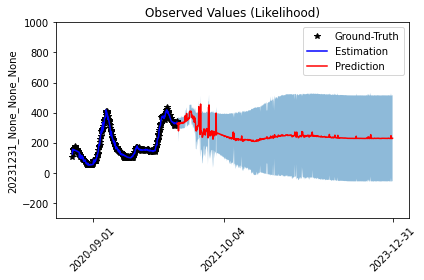

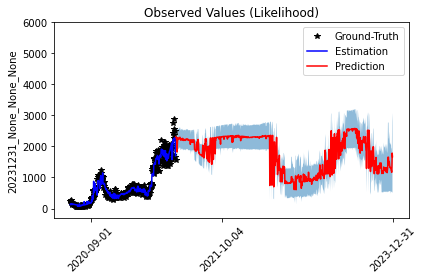

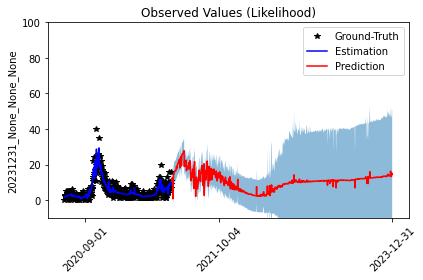

In [50]:
# visualization

with torch.no_grad(), gpytorch.settings.fast_pred_var():
  target_country_list = ['South Korea','United Kingdom','US']
  mode_list = [0,1,2] # 1: infection', 2: death

  for target_country in target_country_list:
    if target_country == target_country_list[0]:
        for mode in mode_list: 
          origin_plot_figure(target_country,mode)

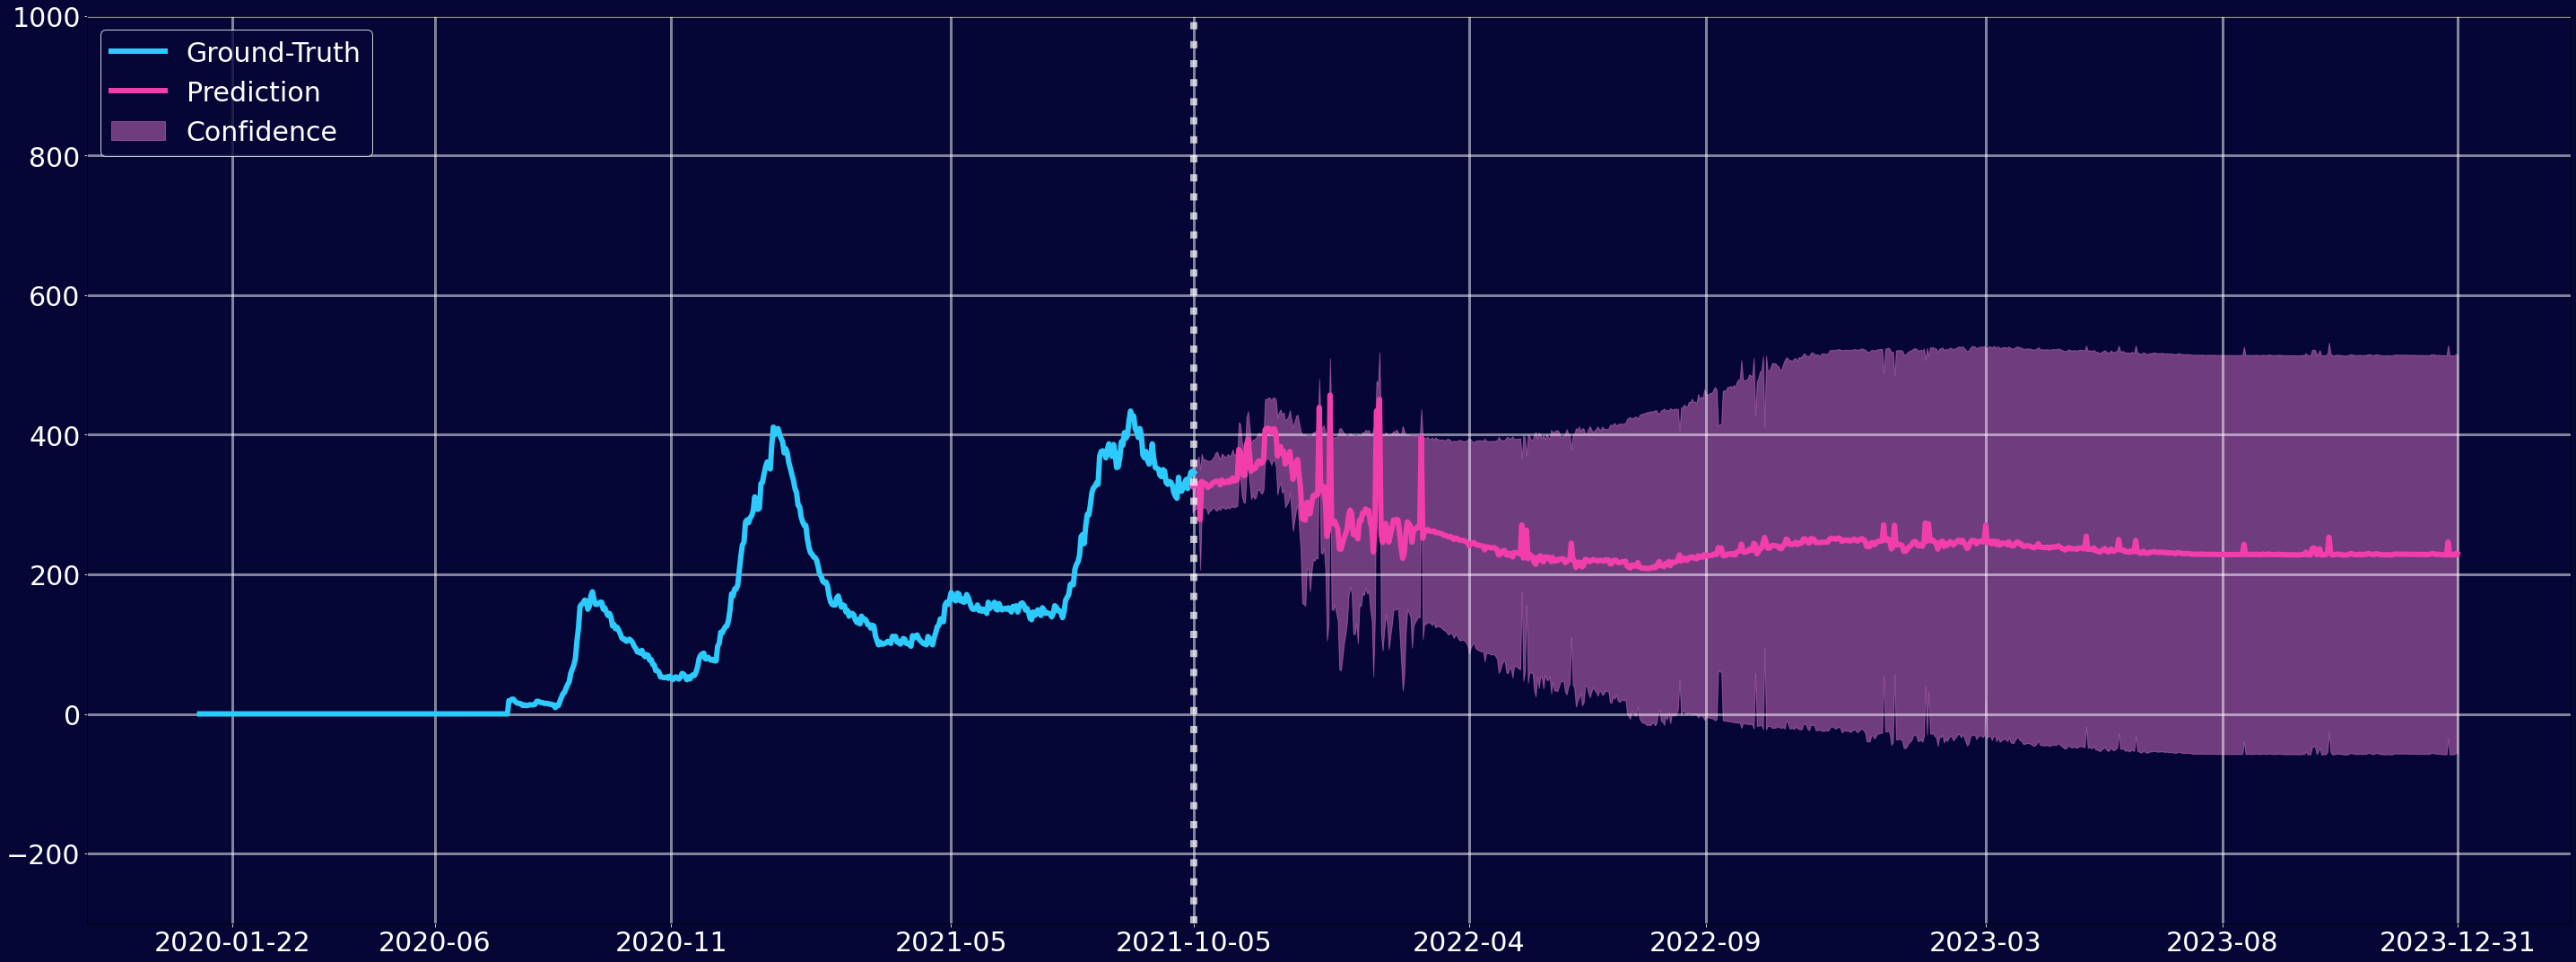

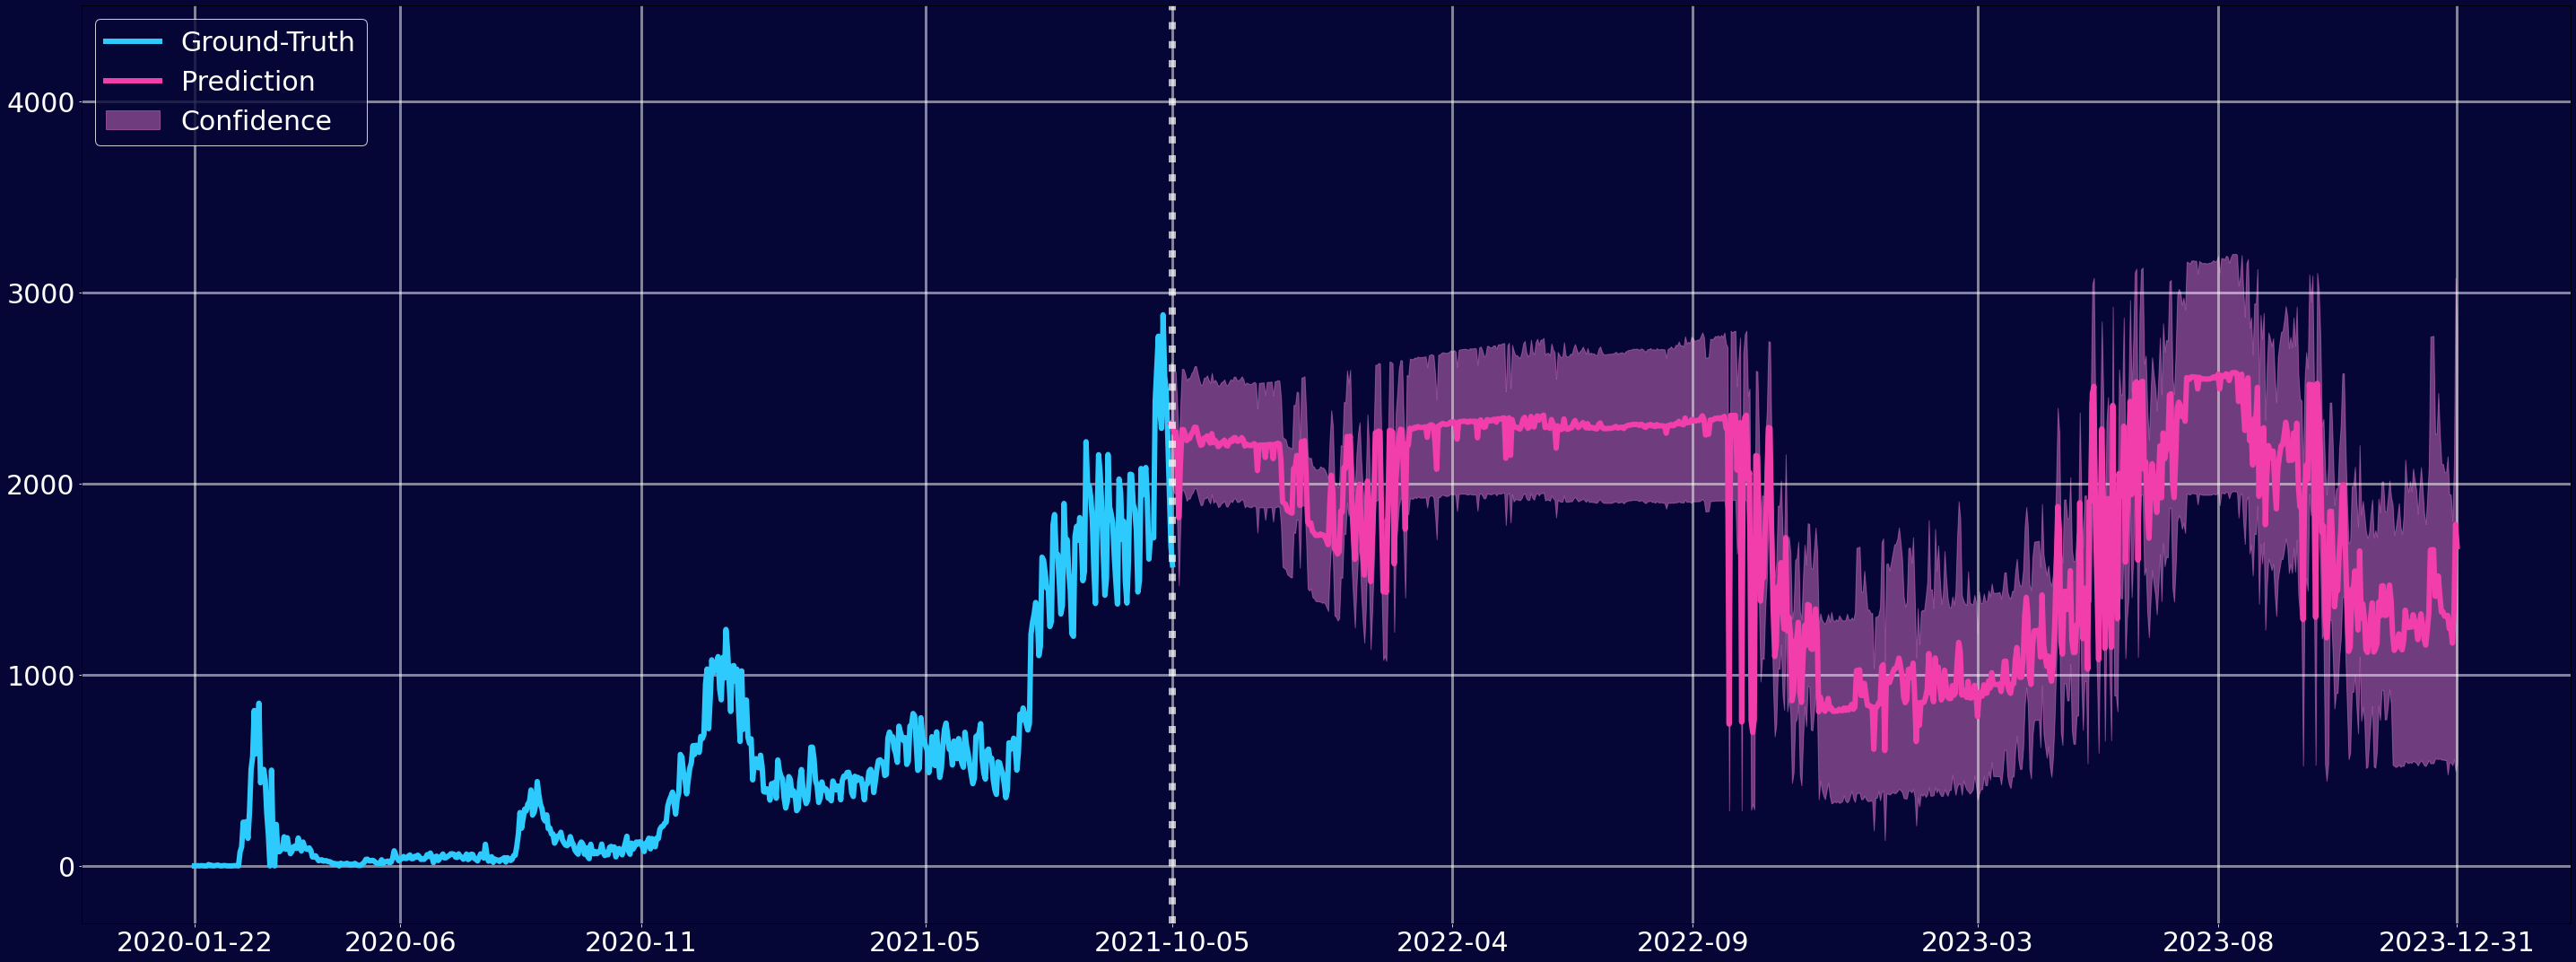

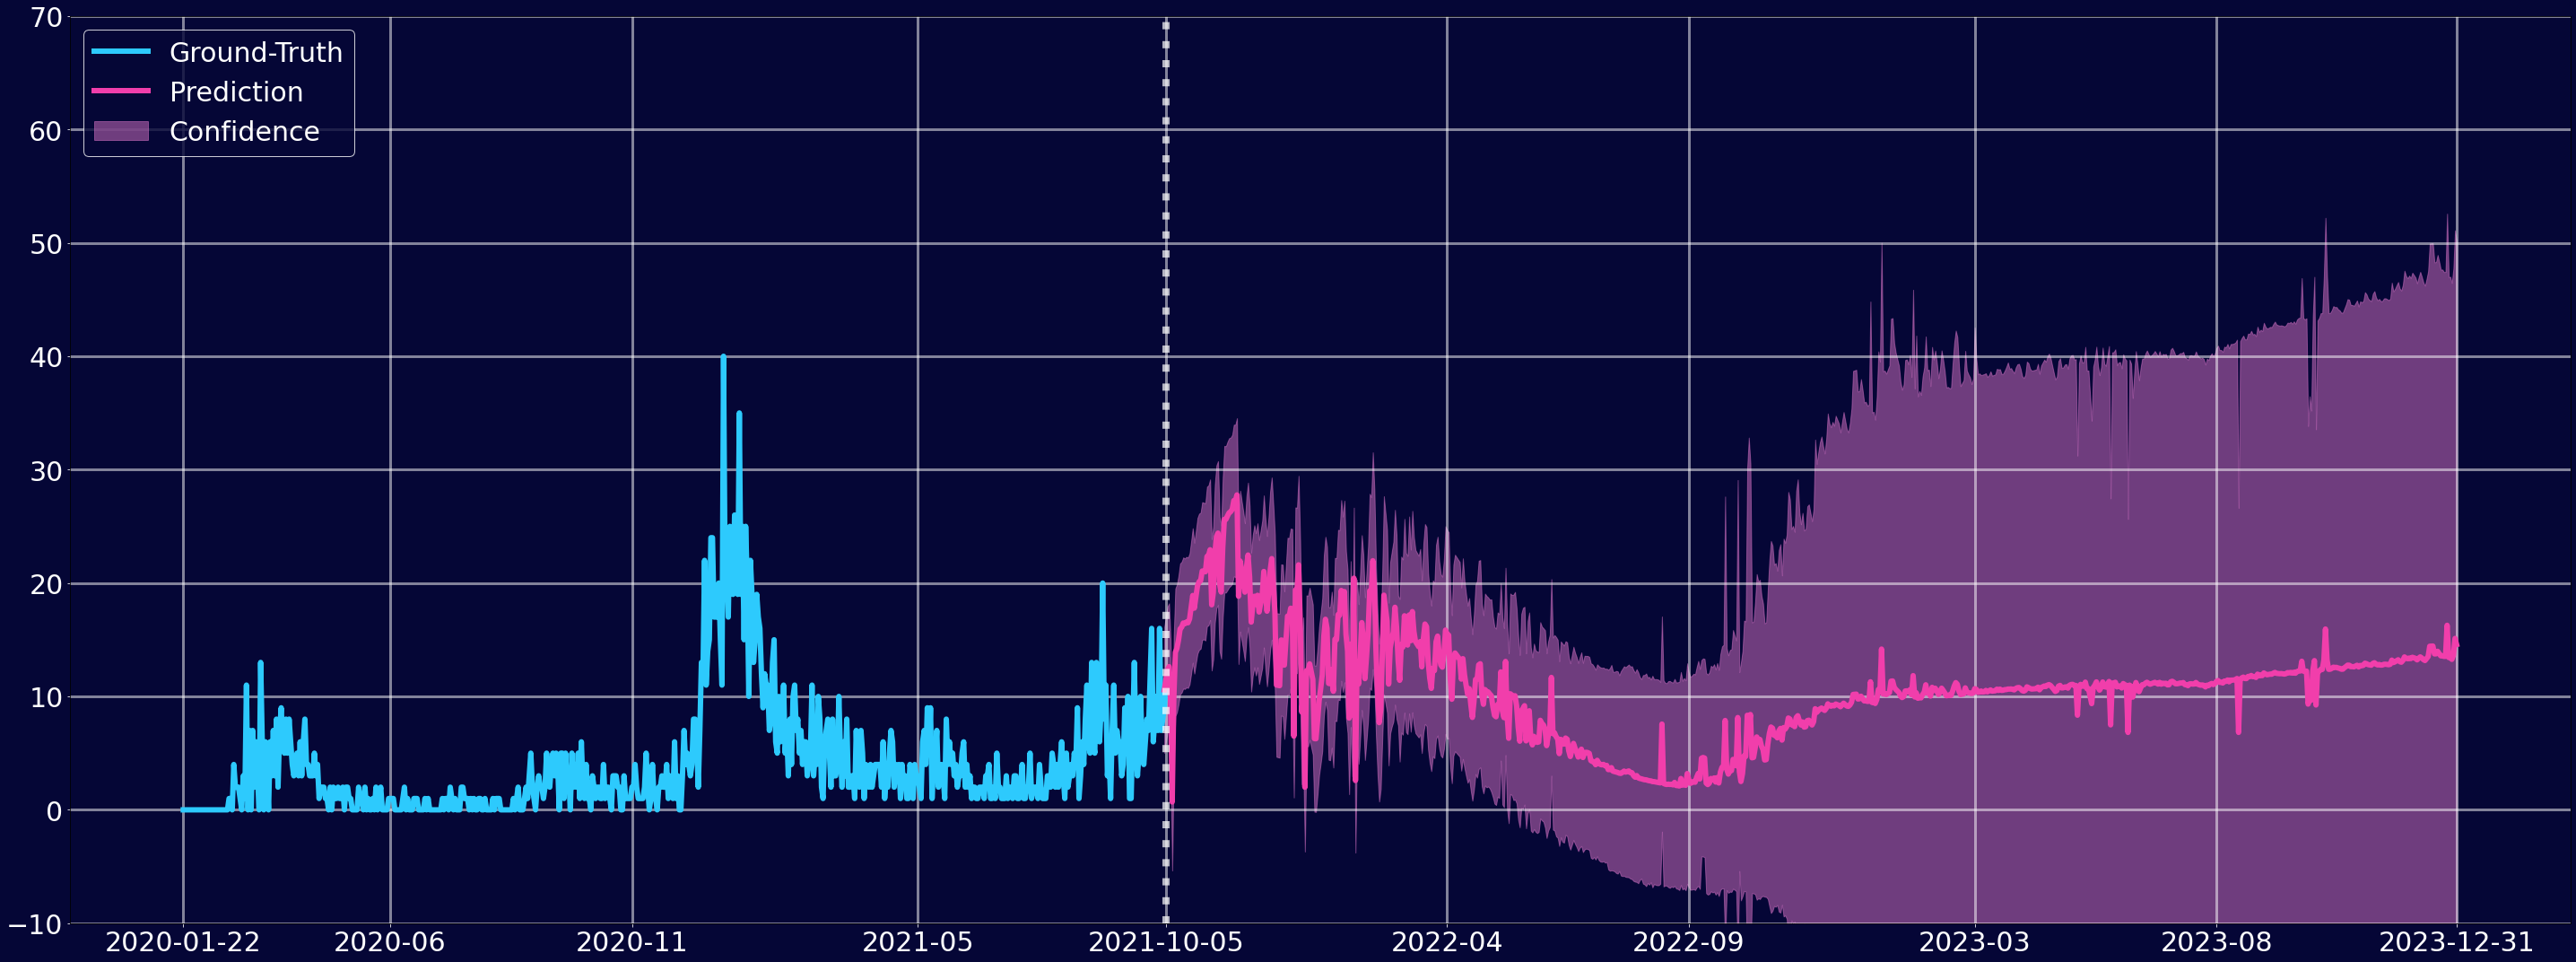

In [51]:
# visualization

with torch.no_grad(), gpytorch.settings.fast_pred_var():
  target_country_list = ['South Korea','United Kingdom','US']
  mode_list = [0,1,2] # 1: infection', 2: death

  for target_country in target_country_list:
    if target_country == target_country_list[0]:
        for mode in mode_list: 
          plot_figure(target_country,mode)